<!-- Notebook Header Start -->

<h1 align="center">Removing DRG stimulation artifacts</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2024-12-4<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Lab  || Neuromechatronics Lab
</p>

---


## 📊 Notebook Outline

* **Import Intan data in RHD format**
* **Package raw data into binary for Kilosort**
* **Run Kilosort to extract spike activity**
* **Calculate average firing rate of each cluster during a window of time.**

## 📚 References & Additional Resources

- [Kilosort4 docs](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface docs](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# 📈 Importing Libraries & Data
---

### imports

In [1]:
# standard imports
from pathlib import Path
import os
import pandas as pd
import numpy as np
from kilosort import io
import matplotlib.pyplot as plt

# custom imports
from automations import RM1
from automations import SpikeInterface_wrapper
from automations import Kilosort_wrapper
from automations import plots

### probe definition

Using the spreadsheet, `Adapter_pinout.xlsx`, the contact ID's can be traced to the "device channel", and we can assign them on the probe. 

In this case, our channel indices correspond to the aux inputs to the intan headstage.

refer to the notebook, `RM1_pipeline.ipynb` within  the `dev_notebook` folder

In [2]:
# Path definitions

# save data to the inbox; make sure that the folders: binary & figures exist
SAVE_DIRECTORY = Path(fr'D:\Data\CMU.80 Data\88 Analyzed Data\88.007 DRGS removed, DW323')  # NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.

# in this case, the data is saved in a folder with multiple rats
DATA_DIRECTORY = Path(fr'D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project')  # NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# Create path if it doesn't exis    t
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)
SAVE_DIRECTORY.mkdir(parents=True, exist_ok=True)
PROBE_DIRECTORY = Path(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.001 A1x32-Edge-5mm-20-177-A32\A1x32-Edge-5mm-20-177-A32.prb')

# 🔁 Identifying an experiment for initial analysis

This is used to determine which trial is most likely to produce good units in a spike sorting analysis

---

### filepath definitions

In [3]:
channel_mapping = pd.read_excel(r"D:\Data\CMU.80 Data\88 Analyzed Data\88.001 A1x32-Edge-5mm-20-177-A32\Adapter_pinout.xlsx",
                                sheet_name="summary",
                                header=2).iloc[:,[8,10,12,14]]
channel_mapping.head(5)

,A1x32 Probe.1,A32->O32 Adapter.1,Intan Board,Intan Input.1
0,32,32,T13,19
1,31,30,T14,20
2,30,31,B13,28
3,29,28,T15,21
4,28,29,B14,27


### importing the rat

In [4]:
Rat = RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, "DW322")

Reading DRGS_10_240918_140034...
Error reading stream 2 for DRGS_10_240918_140034. continuing...
Reading DRGS_11_240918_140803...
Error reading stream 2 for DRGS_11_240918_140803. continuing...
Reading DRGS_12_240918_141655...
Error reading stream 2 for DRGS_12_240918_141655. continuing...
Reading DRGS_1_240918_125448...
Error reading stream 2 for DRGS_1_240918_125448. continuing...
Reading DRGS_2_240918_130024...
Error reading stream 2 for DRGS_2_240918_130024. continuing...
Reading DRGS_3_240918_130835...
Error reading stream 2 for DRGS_3_240918_130835. continuing...
Reading DRGS_4_240918_131552...
Error reading stream 2 for DRGS_4_240918_131552. continuing...
Reading DRGS_5_240918_132233...
Error reading stream 2 for DRGS_5_240918_132233. continuing...
Reading DRGS_6_240918_132920...
Error reading stream 2 for DRGS_6_240918_132920. continuing...
Reading DRGS_7_240918_133719...
Error reading stream 2 for DRGS_7_240918_133719. continuing...
Reading DRGS_8_240918_134529...
Error readin

In [5]:
# for example, pulling the amp data from the 7th DRGS trial (only works for DW333)
# DW322.mat_files_dict["VF_DRG__145435"]["AM"]["amp"][0, 0][0, 0]

In [6]:
Rat.qst_experiment_notes

'd1 tl, d2 am sync, a1 am monitor,a2 evf'

In [7]:
Rat.qst_trial_notes
# Rat.qst_trial_notes.columns

5,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN
Trial Number,,,,,,,,,,
1,1,VF,51,300,5,180,vf,NaN,30,accidentally named DRGS_13
2,2,VF,51,300,20,180,vf,NaN,30,NaN
3,3,VF,51,300,100,180,vf,NaN,30,NaN
4,4,VF,51,300,100,180,vf,NaN,30,NaN
5,5,VF,51,300,5,180,vf,NaN,30,NaN
6,6,VF,51,300,20,180,vf,NaN,30,NaN
7,7,VF,51,300,5,180,vf,NaN,30,NaN
8,8,VF,51,300,100,180,vf,NaN,30,NaN
9,9,VF,51,300,20,180,vf,NaN,30,NaN


In [8]:
# Rat.qst_trial_notes.to_excel(r"D:\Data\CMU.80 Data\88 Analyzed Data\88.004 Initial Analysis, DW322\tables\qst_trial_notes.xlsx")

In [9]:
Rat.get_sc_data()
Rat.sc_data

{'DRGS_10_240918_140034': ChannelSliceRecording: 32 channels - 30.0kHz - 1 segments - 8,650,496 samples 
                        288.35s (4.81 minutes) - uint16 dtype - 527.98 MiB,
 'DRGS_11_240918_140803': ChannelSliceRecording: 32 channels - 30.0kHz - 1 segments - 8,650,496 samples 
                        288.35s (4.81 minutes) - uint16 dtype - 527.98 MiB,
 'DRGS_12_240918_141655': ChannelSliceRecording: 32 channels - 30.0kHz - 1 segments - 8,745,728 samples 
                        291.52s (4.86 minutes) - uint16 dtype - 533.80 MiB,
 'DRGS_1_240918_125448': ChannelSliceRecording: 32 channels - 30.0kHz - 1 segments - 7,750,400 samples 
                        258.35s (4.31 minutes) - uint16 dtype - 473.05 MiB,
 'DRGS_2_240918_130024': ChannelSliceRecording: 32 channels - 30.0kHz - 1 segments - 7,750,400 samples 
                        258.35s (4.31 minutes) - uint16 dtype - 473.05 MiB,
 'DRGS_3_240918_130835': ChannelSliceRecording: 32 channels - 30.0kHz - 1 segments - 7,844,608 sa

In [10]:
Rat.remove_drg_stim_window()

### process data for import into Kilosort

I will use a combination of `SpikeInterface` & `Kilosort.io.extractors` to get the data I need

In [11]:
signals = SpikeInterface_wrapper(Rat, SAVE_DIRECTORY)

Preparing SpikeInterface wrapper for rat DW322


In [12]:
# VF_DRG_pre = "VF_DRG_1_241115_145120"
VF_DRG_pre = "VF_2_240918_143936"
VF_DRG_post = "VF_DRG_1_241115_145739"

In [13]:
recording_pre = signals.data.intan_recordings_stream0[VF_DRG_pre]
digital_trace_pre = signals.data.intan_recordings_stream4[VF_DRG_pre].get_traces(channel_ids=['DIGITAL-IN-01'])
von_frey_pre = signals.data.intan_recordings_stream3[VF_DRG_pre]

In [25]:
from spikeinterface import concatenate_recordings

# Assume 'base_recording' is your original recording
base_recording = signals.data.intan_recordings_stream0[VF_DRG_pre]

# Slice the first 100,000 frames
recording_first = base_recording.frame_slice(start_frame=0, end_frame=1000000)

# Get the total number of frames in the base recording
total_frames = base_recording.get_num_frames()

# Slice the last 500,000 frames
recording_last = base_recording.frame_slice(start_frame=total_frames - 1000000, end_frame=total_frames)

# Concatenate the two recordings into one
recording_combined = concatenate_recordings([recording_first, recording_last])

# Save the combined recording as a single binary file
# save_folder = '/path/to/save_folder'  # Replace with your desired path
# recording_combined.save(folder=save_folder, format='binary')


von_frey_pre = signals.data.intan_recordings_stream3[VF_DRG_pre]
vf_first = von_frey_pre.frame_slice(start_frame=0, end_frame=1050000)
vf_last = von_frey_pre.frame_slice(start_frame=total_frames - 1050000, end_frame=total_frames)
von_frey_pre = concatenate_recordings([vf_first, vf_last])


In [26]:
# recording_post = signals.data.intan_recordings_stream0[VF_DRG_post]
# digital_trace_post = signals.data.intan_recordings_stream4[VF_DRG_post].get_traces(channel_ids=['DIGITAL-IN-01'])
# von_frey_post = signals.data.intan_recordings_stream3[VF_DRG_post]

In [27]:
# plots.static_trace(von_frey_pre,channel_id='ANALOG-IN-2',start_time=0, end_time=1000)
# von_frey_pre = signals.data.intan_recordings_stream3[VF_DRG_pre]
plots.interactive_trace(von_frey_pre,channel_id='ANALOG-IN-2',downsample_factor=1000)

gain_to_uV: 312.5, offset_to_uV: -10240000.0


In [17]:
von_frey_pre = signals.data.intan_recordings_stream3[VF_DRG_pre]
# plots.static_trace(von_frey_pre,channel_id='ANALOG-IN-2',start_time=0, end_time=1000)
plots.interactive_trace(von_frey_pre,channel_id='ANALOG-IN-2',downsample_factor=1000)

gain_to_uV: 312.5, offset_to_uV: -10240000.0


In [18]:
# plots.interactive_trace(recording_post)

In [19]:
# plots.static_trace(von_frey_post,channel_id='ANALOG-IN-2',start_time=0, end_time=1000)

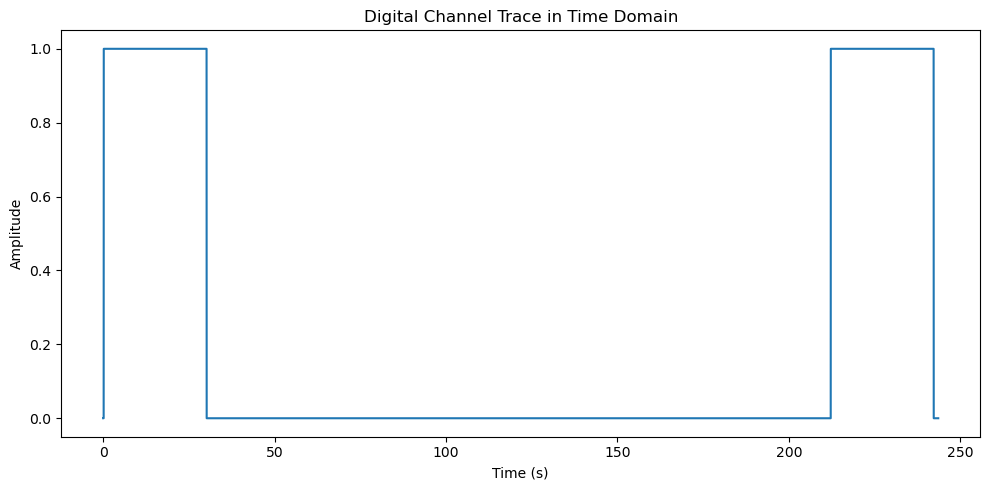

In [20]:
# Calculate the time vector
sampling_rate = 30000  # in Hz
num_samples = len(digital_trace_pre)
time_vector = np.arange(num_samples) / sampling_rate  # Time in seconds

# Plot the digital trace in the time domain
plt.figure(figsize=(10, 5))
plt.plot(time_vector, digital_trace_pre)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Digital Channel Trace in Time Domain')
plt.tight_layout()
plt.show()


In [21]:
# # Calculate the time vector
# sampling_rate = 30000  # in Hz
# num_samples = len(digital_trace_post)
# time_vector = np.arange(num_samples) / sampling_rate  # Time in seconds

# # Plot the digital trace in the time domain
# plt.figure(figsize=(10, 5))
# plt.plot(time_vector, digital_trace_post)
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.title('Digital Channel Trace in Time Domain')
# plt.tight_layout()
# plt.show()

# Extract windows of time where Von Frey stimulus is applied, calculate average stimulus and ECAP

Adjusted Time Windows:
[[  3.5451       4.52403333]
 [  6.66833333  10.6714    ]
 [ 12.75246667  15.44296667]
 [ 17.14026667  20.28273333]
 [ 23.02313333  24.3134    ]
 [ 26.7741      27.46513333]
 [ 30.396       31.9024    ]
 [ 94.38573333  94.61753333]
 [216.25216667 216.98376667]
 [218.87566667 220.7398    ]
 [222.6598     225.53906667]
 [227.5347     228.25756667]
 [230.29186667 233.4049    ]
 [237.0605     238.2632    ]
 [240.008      242.69846667]]
Average Von Frey responses during adjusted intervals:
[286865.66 536212.4  525377.25 783055.5  551753.   550194.25 606806.2
 316194.53 303024.22 478653.25 608869.94 434464.66 352815.03 459119.3
 679592.2 ]
Average recording responses during adjusted intervals (per channel):
[[ 6.71210337e+00  1.99865456e+01  2.03780403e+01 -1.10995464e+01
  -1.76592579e+01 -1.27879486e+01 -1.07624474e+01 -5.76585083e+01
  -6.81376648e+01  3.90735078e+00  2.08031120e+01  3.43297005e+01
   1.00468950e+01  4.78607750e+01  4.46907692e+01  4.00785370e+01
  

C:\Users\KarlJ\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



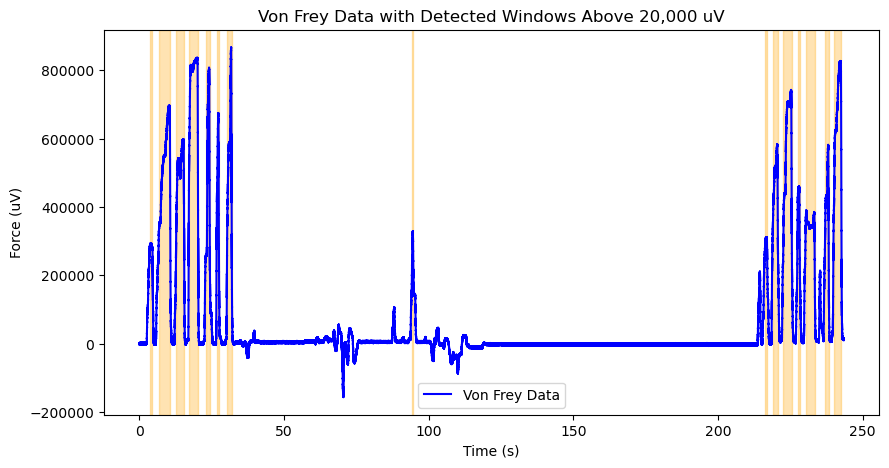

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Extract Von Frey data (assuming 'ANALOG-IN-2' is the correct channel)
von_frey_data = von_frey_pre.get_traces(channel_ids=['ANALOG-IN-2'], return_scaled=True).flatten()

# Sampling rate of the recording
sampling_rate = 30000  # Hz


#
#
# setting an amplitue threshold
#
#
# Set an amplitude threshold to identify crossings
amplitude_threshold = 250000  # Set to 20,000 microvolts

# Find indices where the von_frey_data crosses above the threshold (rising edge)
rising_edges = np.where((von_frey_data[:-1] < amplitude_threshold) & (von_frey_data[1:] >= amplitude_threshold))[0] + 1

# Find indices where the von_frey_data crosses below the threshold (falling edge)
falling_edges = np.where((von_frey_data[:-1] >= amplitude_threshold) & (von_frey_data[1:] < amplitude_threshold))[0] + 1

# Handle cases where the trace starts above the threshold
if von_frey_data[0] >= amplitude_threshold:
    rising_edges = np.insert(rising_edges, 0, 0)

# Handle cases where the trace ends above the threshold
if von_frey_data[-1] >= amplitude_threshold:
    falling_edges = np.append(falling_edges, len(von_frey_data) - 1)

# Ensure that the number of rising and falling edges matches
if len(rising_edges) > len(falling_edges):
    rising_edges = rising_edges[:len(falling_edges)]
elif len(falling_edges) > len(rising_edges):
    falling_edges = falling_edges[:len(rising_edges)]

# Define the time windows based on these edges
start_times = rising_edges / sampling_rate
end_times = falling_edges / sampling_rate

# Define buffers in seconds (optional)
start_buffer = 0.1  # Time to add to the start of each interval
end_buffer = 0.05   # Time to subtract from the end of each interval

# Adjust the time windows with buffers
adjusted_start_times = start_times + start_buffer
adjusted_end_times = end_times - end_buffer

# Ensure that the adjusted times are within valid bounds
valid_indices = adjusted_start_times < adjusted_end_times

# Apply the valid indices to filter out any invalid intervals
adjusted_start_times = adjusted_start_times[valid_indices]
adjusted_end_times = adjusted_end_times[valid_indices]

# Convert adjusted times back to sample indices
adjusted_start_indices = (adjusted_start_times * sampling_rate).astype(int)
adjusted_end_indices = (adjusted_end_times * sampling_rate).astype(int)

# Ensure indices are within the valid range
num_samples = len(von_frey_data)
adjusted_start_indices = np.clip(adjusted_start_indices, 0, num_samples - 1)
adjusted_end_indices = np.clip(adjusted_end_indices, 0, num_samples - 1)

# Get recording data (all channels or specify channel_ids as needed)
recording_data = recording_pre.get_traces(return_scaled=True)

# Initialize lists to store averages
von_frey_averages = []
recording_averages = []

# Loop over each adjusted time window
for start_idx, end_idx in zip(adjusted_start_indices, adjusted_end_indices):
    # Extract data segments corresponding to the adjusted time window
    von_frey_segment = von_frey_data[start_idx:end_idx]
    recording_segment = recording_data[start_idx:end_idx, :]  # All channels during the time window

    # Compute averages
    von_frey_avg = np.mean(von_frey_segment)
    recording_avg = np.mean(recording_segment, axis=0)  # Average across time for each channel

    # Store the averages
    von_frey_averages.append(von_frey_avg)
    recording_averages.append(recording_avg)

# Convert lists to arrays for easier manipulation
von_frey_averages = np.array(von_frey_averages)
recording_averages = np.array(recording_averages)

# Now you have the average Von Frey and recording responses during the adjusted intervals
print("Adjusted Time Windows:")
print(np.column_stack((adjusted_start_times, adjusted_end_times)))

print("Average Von Frey responses during adjusted intervals:")
print(von_frey_averages)

print("Average recording responses during adjusted intervals (per channel):")
print(recording_averages)

# Optional: Plot the Von Frey data with the detected windows
time_vector = np.arange(len(von_frey_data)) / sampling_rate

plt.figure(figsize=(10, 5))
plt.plot(time_vector, von_frey_data, label='Von Frey Data', color='blue')
for start, end in zip(adjusted_start_times, adjusted_end_times):
    plt.axvspan(start, end, color='orange', alpha=0.3)

plt.xlabel('Time (s)')
plt.ylabel('Force (uV)')
plt.title('Von Frey Data with Detected Windows Above 20,000 uV')
plt.legend()
plt.show()


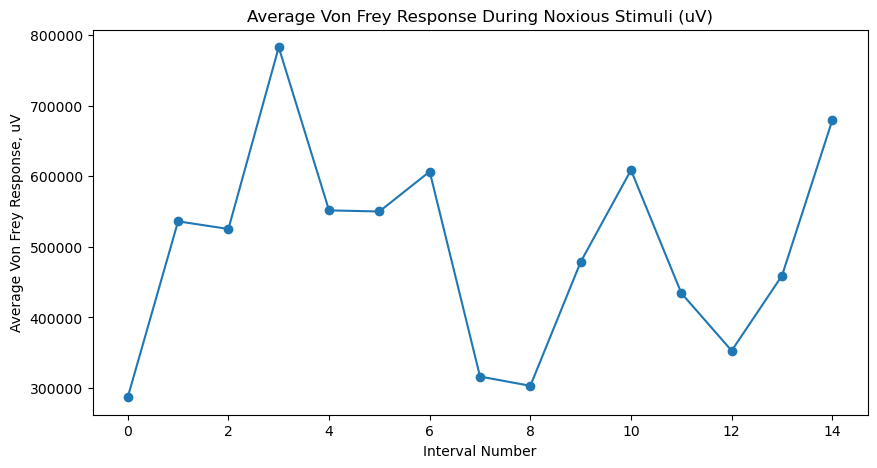

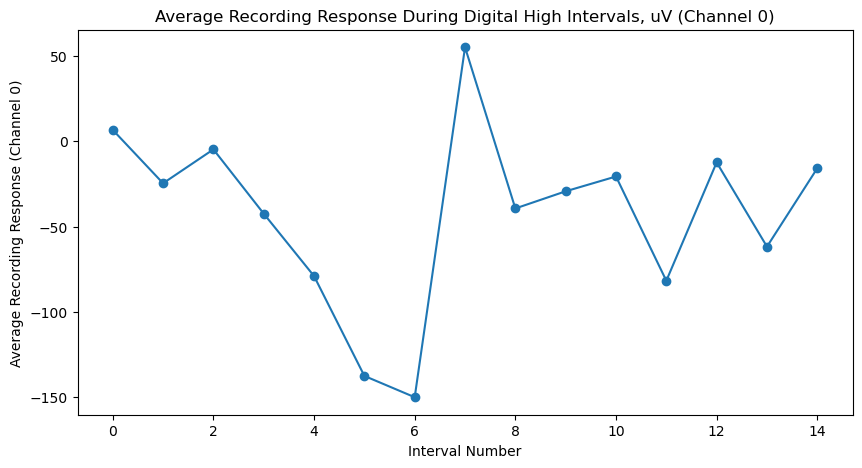

In [23]:
channel_number = 1  # Change to the channel you're interested in

# Plot the average Von Frey response during each interval
plt.figure(figsize=(10, 5))
plt.plot(von_frey_averages, marker='o')
plt.xlabel('Interval Number')
plt.ylabel('Average Von Frey Response, uV')
plt.title('Average Von Frey Response During Noxious Stimuli (uV)')
plt.show()

# Plot the average recording response for a specific channel (e.g., channel 0)
channel_number = 0  # Change to the channel you're interested in
plt.figure(figsize=(10, 5))
plt.plot(recording_averages[:, channel_number], marker='o')
plt.xlabel('Interval Number')
plt.ylabel(f'Average Recording Response (Channel {channel_number})')
plt.title(f'Average Recording Response During Digital High Intervals, uV (Channel {channel_number})')
plt.show()


# 🖼 Export Results to binary and run Kilosort trial summary

### run trial review

Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.007 DRGS removed, DW323\binary\DRGS_10_240918_140034\DW322_DRGS_10_240918_140034_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.007 DRGS removed, DW323\binary\DRGS_11_240918_140803\DW322_DRGS_11_240918_140803_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.007 DRGS removed, DW323\binary\DRGS_12_240918_141655\DW322_DRGS_12_240918_141655_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.007 DRGS removed, DW323\binary\DRGS_1_240918_125448\DW322_DRGS_1_240918_125448_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.007 DRGS removed, DW323\binary\DRGS_2_240918_130024\DW322_DRGS_2_240918_130024_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.007 DRGS removed, DW323\binary\DRGS_3_240918_130835\DW322_DRGS_3_240918_130835_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.007 DRGS removed, DW323\binary\DRGS_4_240918_131552\DW322_DRGS_4_240918_131552_data.bin


kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.007 DRGS removed, DW323\binary\DRGS_10_240918_140034\DW322_DRGS_10_240918_140034_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------


ERROR: issue importing data for VF_2_240918_143936
Preparing Kilosort wrapper...
|
|
|
|
|
|
Running kilosort on DRGS_10_240918_140034
|
|
|
|
|
|


kilosort.run_kilosort: N samples: 2100000
kilosort.run_kilosort: N seconds: 70.0
kilosort.run_kilosort: N batches: 35
kilosort.run_kilosort: Preprocessing filters computed in  0.41s; total  0.42s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     9.60 %
kilosort.run_kilosort: Memory:       63.42 %     |     30.40   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   14.22 %     |      1.14   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     1.47 %     |      0.12   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computin

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Data\\CMU.80 Data\\88 Analyzed Data\\88.007 DRGS removed, DW323\\figures\\spike_summary_DRGS_10_240918_140034.png'

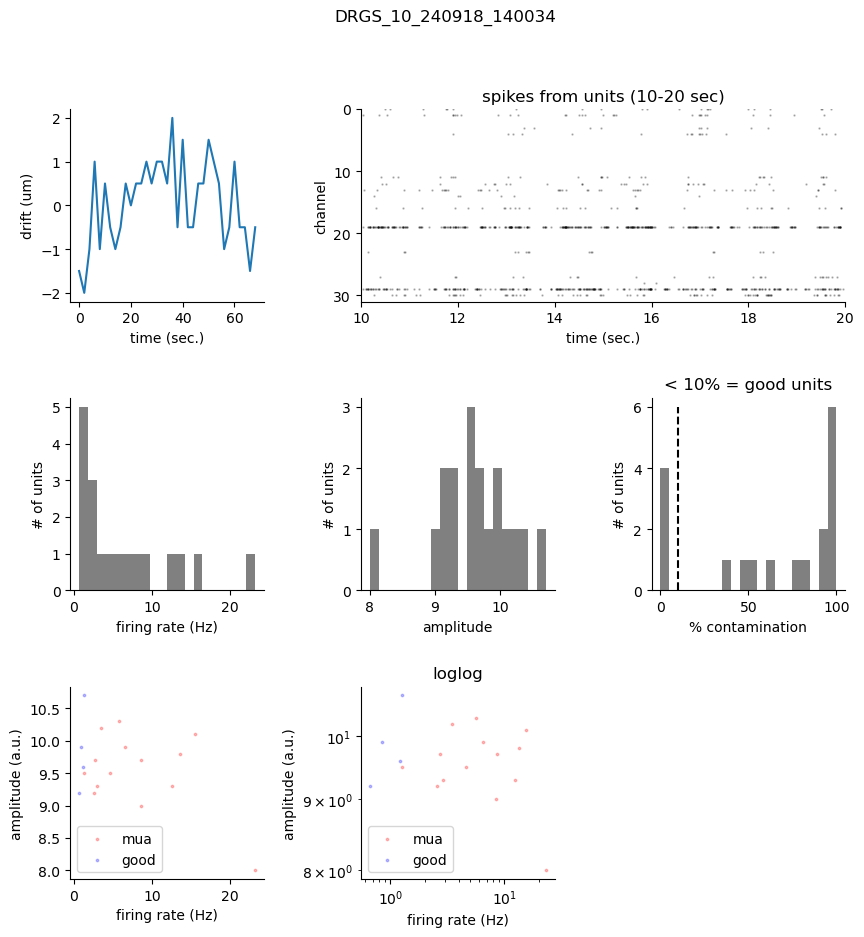

In [24]:
# # signals.save_spinalcord_data_to_binary(TRIAL_NAMES=["VF_8_241125_161626",
# # #                                                      ])
signals.save_spinalcord_data_to_binary()

spikes = Kilosort_wrapper(SAVE_DIRECTORY, PROBE_DIRECTORY)

# # NOTE: running the trial summary will take some time. I've commented it out. if you need to generate kilosort outputs, then uncomment
spikes.run_kilosort_trial_summary()

### import results from kilosort to run further analysis

In [ ]:
spikes.extract_kilosort_outputs()

- **`ops`**: Loads the Kilosort options dictionary, which includes parameters and processing information.
- **`cluster_amplitudes` & `contamination_percentage`**: Load cluster amplitudes and contamination percentages from TSV files.
- **`channel_mapping`**: Loads the mapping of electrode channels.
- **`templates`**: Loads the spike waveform templates.
- **`chan_best`**: Identifies the best (most representative) channel for each template by finding the channel with the maximum energy (sum of squared amplitudes).
- **`amplitudes`**: Loads the amplitudes of detected spikes.
- **`spike_times`**: Loads spike times, typically in sample indices.
- **`spike_clusters`**: Loads cluster assignments for each spike.
- **`firing_rates`**: Calculates the firing rate for each unit (cluster) by counting the number of spikes and normalizing by the total recording time.
- **`dshift`**: Extracts the drift shift values from the options dictionary, which indicates the movement of the recording probe over time.

In [ ]:
spikes.kilosort_results["VF_1_240918_143256"]

In [ ]:
from collections import Counter
# Get spike times and clusters from Kilosort results
# Assuming the results are stored in spikes.kilosort_results
# Use the appropriate trial name
trial_name = VF_DRG_pre  # Ensure this matches your actual trial name in kilosort_results
kilosort_output = spikes.kilosort_results[trial_name]

st = kilosort_output['spike_times']  # Spike times in samples
clu = kilosort_output['spike_clusters']  # Cluster assignments
sampling_rate_kilosort = kilosort_output['ops']['fs']  # Sampling rate used in Kilosort (should match)

# Convert spike times to seconds
spike_times_sec = st / sampling_rate_kilosort

# Initialize a list to store firing rates per interval
firing_rates_intervals = []

# Loop over each adjusted time window
for start_time, end_time in zip(adjusted_start_times, adjusted_end_times):
    # Find spikes within the time window
    indices_in_window = np.where((spike_times_sec >= start_time) & (spike_times_sec < end_time))[0]
    spikes_in_window = st[indices_in_window]
    clusters_in_window = clu[indices_in_window]
    
    # Calculate the duration of the interval
    window_duration = end_time - start_time  # In seconds
    
    # Count the number of spikes per cluster within the window
    cluster_spike_counts = Counter(clusters_in_window)
    
    # Get all clusters present in the entire recording
    all_clusters = np.unique(clu)
    
    # Initialize firing rates with zero for all clusters
    firing_rates = {cluster: 0 for cluster in all_clusters}
    
    # Compute firing rates for clusters present in the window
    for cluster in all_clusters:
        count = cluster_spike_counts.get(cluster, 0)
        firing_rates[cluster] = count / window_duration  # Firing rate in Hz
    
    # Append the firing rates dictionary to the list
    firing_rates_intervals.append(firing_rates)

# Convert the list of dictionaries to a DataFrame
# Each row corresponds to an interval, columns are clusters
firing_rates_df = pd.DataFrame(firing_rates_intervals)

# Optionally, fill NaN values with zeros (clusters not firing in an interval)
firing_rates_df = firing_rates_df.fillna(0)

# Display the firing rates DataFrame
print("Firing Rates during Adjusted Intervals (Hz):")
print(firing_rates_df)

# Plotting the firing rates for a specific cluster across intervals
cluster_to_plot = all_clusters[0]  # Replace with the cluster you're interested in
plt.figure(figsize=(10, 5))
plt.plot(firing_rates_df[cluster_to_plot], marker='o')
plt.xlabel('Interval Number')
plt.ylabel('Firing Rate (Hz)')
plt.title(f'Firing Rate of Cluster {cluster_to_plot} Across Intervals')
plt.show()

# Optionally, plot the firing rates of all clusters as a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(firing_rates_df.T, aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Firing Rate (Hz)')
plt.xlabel('Interval Number')
plt.ylabel('Cluster')
plt.yticks(ticks=np.arange(len(all_clusters)), labels=all_clusters)
plt.title('Firing Rates of Clusters Across Intervals')
plt.show()

In [ ]:
firing_rates_df

In [ ]:

# Calculate the standard deviation for each cluster across intervals
std_firing_rates = firing_rates_df.std(axis=0)

# Determine a threshold for "significant change" in firing rate
# For example, clusters with a standard deviation greater than the median are highlighted
threshold = std_firing_rates.median()

# Identify units that show significant changes versus stable units
significant_units = std_firing_rates > threshold
stable_units = ~significant_units

# Plotting
plt.figure(figsize=(18, 6))

# Plot the stable units with low opacity and thinner lines
for cluster in firing_rates_df.columns[stable_units]:
    plt.plot(firing_rates_df[cluster], marker='o', linestyle='-', linewidth=1, alpha=0.5, color='gray')

# Plot the significant units with higher opacity and thicker lines
for cluster in firing_rates_df.columns[significant_units]:
    plt.plot(firing_rates_df[cluster], marker='o', linestyle='-', linewidth=2, alpha=0.9, label=f'Cluster {cluster}')

# Highlighting
plt.xlabel('Von Frey Trial', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Firing Rates of Clusters Across Von Frey Trials', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optional: Add a legend for clusters with significant changes outside the plot
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small', frameon=False)

# Adjust layout to accommodate the legend outside the plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the plot area to make space for the legend
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.004 Initial Analysis, DW322\figures\firing_rates.png', dpi=300, bbox_inches='tight')
plt.show()


## extracting spikes in useful range of 2Hz to 15Hz

(1) Hao, H.; Ramli, R.; Wang, C.; Liu, C.; Shah, S.; Mullen, P.; Lall, V.; Jones, F.; Shao, J.; Zhang, H.; Jaffe, D. B.; Gamper, N.; Du, X. Dorsal Root Ganglia Control Nociceptive Input to the Central Nervous System. PLoS Biol 2023, 21 (1), e3001958. https://doi.org/10.1371/journal.pbio.3001958.


In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming `spikes` is a Kilosort_wrapper instance and `VF_DRG_pre` is the trial name
trial_name = VF_DRG_pre
kilosort_output = spikes.kilosort_results[trial_name]

st = kilosort_output['spike_times']  # Spike times in samples
clu = kilosort_output['spike_clusters']  # Cluster assignments
sampling_rate_kilosort = kilosort_output['ops']['fs']  # Sampling rate used in Kilosort (should match)

# Convert spike times to seconds
spike_times_sec = st / sampling_rate_kilosort

# Initialize a list to store firing rates per interval
firing_rates_intervals = []

# Loop over each adjusted time window
for start_time, end_time in zip(adjusted_start_times, adjusted_end_times):
    # Find spikes within the time window
    indices_in_window = np.where((spike_times_sec >= start_time) & (spike_times_sec < end_time))[0]
    spikes_in_window = st[indices_in_window]
    clusters_in_window = clu[indices_in_window]
    
    # Calculate the duration of the interval
    window_duration = end_time - start_time  # In seconds
    
    # Count the number of spikes per cluster within the window
    cluster_spike_counts = Counter(clusters_in_window)
    
    # Get all clusters present in the entire recording
    all_clusters = np.unique(clu)
    
    # Initialize firing rates with zero for all clusters
    firing_rates = {cluster: 0 for cluster in all_clusters}
    
    # Compute firing rates for clusters present in the window
    for cluster in all_clusters:
        count = cluster_spike_counts.get(cluster, 0)
        firing_rates[cluster] = count / window_duration  # Firing rate in Hz
    
    # Append the firing rates dictionary to the list
    firing_rates_intervals.append(firing_rates)

# Convert the list of dictionaries to a DataFrame
# Each row corresponds to an interval, columns are clusters
firing_rates_df = pd.DataFrame(firing_rates_intervals)

# Optionally, fill NaN values with zeros (clusters not firing in an interval)
firing_rates_df = firing_rates_df.fillna(0)

# Calculate the average firing rate for each cluster across all intervals
average_firing_rates = firing_rates_df.mean()

# Filter clusters with average firing rates between 2.5Hz and 15Hz
filtered_clusters = average_firing_rates[(average_firing_rates >= 2) & (average_firing_rates <= 15)].index

# Filter the firing rates DataFrame to only include the desired clusters
firing_rates_df_filtered = firing_rates_df[filtered_clusters]

# Display the filtered firing rates DataFrame
print("Filtered Firing Rates during Adjusted Intervals (Hz):")
print(firing_rates_df_filtered)

# Plotting the firing rates for a specific filtered cluster across intervals
if not filtered_clusters.empty:
    cluster_to_plot = filtered_clusters[0]  # Replace with the cluster you're interested in
    plt.figure(figsize=(10, 5))
    plt.plot(firing_rates_df_filtered[cluster_to_plot], marker='o')
    plt.xlabel('Interval Number')
    plt.ylabel('Firing Rate (Hz)')
    plt.title(f'Firing Rate of Cluster {cluster_to_plot} Across Intervals')
    plt.show()

# Optionally, plot the firing rates of all filtered clusters as a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(firing_rates_df_filtered.T, aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Firing Rate (Hz)')
plt.xlabel('Interval Number')
plt.ylabel('Cluster')
plt.yticks(ticks=np.arange(len(filtered_clusters)), labels=filtered_clusters)
plt.title('Firing Rates of Filtered Clusters Across Intervals')
plt.show()


In [ ]:
# Calculate the standard deviation for each cluster across intervals (only for filtered clusters)
std_firing_rates_filtered = firing_rates_df_filtered.std(axis=0)

# Determine a threshold for "significant change" in firing rate (using median of filtered clusters)
threshold_filtered = std_firing_rates_filtered.median()

# Identify units that show significant changes versus stable units among filtered clusters
significant_units_filtered = std_firing_rates_filtered > threshold_filtered
stable_units_filtered = ~significant_units_filtered

# Plotting only the filtered clusters
plt.figure(figsize=(18, 6))

# Plot the stable units with low opacity and thinner lines (filtered clusters only)
for cluster in firing_rates_df_filtered.columns[stable_units_filtered]:
    plt.plot(firing_rates_df_filtered[cluster], marker='o', linestyle='-', linewidth=1, alpha=0.5, color='gray')

# Plot the significant units with higher opacity and thicker lines (filtered clusters only)
for cluster in firing_rates_df_filtered.columns[significant_units_filtered]:
    plt.plot(firing_rates_df_filtered[cluster], marker='o', linestyle='-', linewidth=2, alpha=0.9, label=f'Cluster {cluster}')

# Highlighting
plt.xlabel('Von Frey Trial', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Firing Rates of Filtered Clusters Across Von Frey Trials', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optional: Add a legend for clusters with significant changes outside the plot
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small', frameon=False)

# Adjust layout to accommodate the legend outside the plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the plot area to make space for the legend
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.004 Initial Analysis, DW322\figures\firing_rates_filtered.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Split data into first 7 and last 7 trials
first_half_indices = list(range(7))
second_half_indices = list(range(7, 14))

# Extract data for the first 7 and last 7 trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

firing_rates_first_half = firing_rates_df_filtered.iloc[first_half_indices].mean(axis=1)
firing_rates_second_half = firing_rates_df_filtered.iloc[second_half_indices].mean(axis=1)

# Create a pandas DataFrame with the results
data = {
    "Trial Set": ["First 7 Trials"] * 7 + ["Last 7 Trials"] * 7,
    "Von Frey Voltage (uV)": list(von_frey_first_half) + list(von_frey_second_half),
    "Average Firing Rate (Hz)": list(firing_rates_first_half) + list(firing_rates_second_half)
}

df_comparison = pd.DataFrame(data)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Get the total number of trials available
total_trials = len(von_frey_averages)

# Calculate midpoint to split the trials into two halves
mid_point = total_trials // 2

# Split data into first half and second half of trials
first_half_indices = list(range(mid_point))
second_half_indices = list(range(mid_point, total_trials))

# Extract data for the first and last half of trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

firing_rates_first_half = firing_rates_df_filtered.iloc[first_half_indices].mean(axis=1)
firing_rates_second_half = firing_rates_df_filtered.iloc[second_half_indices].mean(axis=1)

# Create a pandas DataFrame with the results
data = {
    "Trial Set": ["First Half Trials"] * len(first_half_indices) + ["Second Half Trials"] * len(second_half_indices),
    "Von Frey Voltage (uV)": list(von_frey_first_half) + list(von_frey_second_half),
    "Average Firing Rate (Hz)": list(firing_rates_first_half) + list(firing_rates_second_half)
}

df_comparison = pd.DataFrame(data)

# Display the DataFrame
print(df_comparison)

# Scatter plot the relationship between Von Frey voltage and spiking rate for each group
plt.figure(figsize=(10, 6))

# Scatter plot for the first half trials
plt.scatter(von_frey_first_half, firing_rates_first_half, color='blue', alpha=0.7, label='First Half Trials')

# Scatter plot for the second half trials
plt.scatter(von_frey_second_half, firing_rates_second_half, color='red', alpha=0.7, label='Second Half Trials')

# Calculate and plot trend lines
# First half trend line
slope, intercept, r_value, p_value, std_err = linregress(von_frey_first_half, firing_rates_first_half)
trendline_first_half = intercept + slope * np.array(von_frey_first_half)
plt.plot(von_frey_first_half, trendline_first_half, color='blue', linestyle='--', linewidth=2)

# Second half trend line
slope, intercept, r_value, p_value, std_err = linregress(von_frey_second_half, firing_rates_second_half)
trendline_second_half = intercept + slope * np.array(von_frey_second_half)
plt.plot(von_frey_second_half, trendline_second_half, color='red', linestyle='--', linewidth=2)

# Labels and legend
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Average Firing Rate (Hz)', fontsize=14)
plt.title('Average Firing Rate vs Von Frey Voltage', fontsize=16)
plt.legend(title='Trial Group', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot if needed
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW333\figures\von_frey_vs_firing_rate_trendline.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Get the total number of trials available
total_trials = len(von_frey_averages)

# Calculate midpoint to split the trials into two halves
mid_point = total_trials // 2

# Split data into first half and second half of trials
first_half_indices = list(range(mid_point))
second_half_indices = list(range(mid_point, total_trials))

# Extract data for the first and last half of trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

# Filter firing rates for first and second half for each cluster
firing_rates_first_half = firing_rates_df_filtered.iloc[first_half_indices]
firing_rates_second_half = firing_rates_df_filtered.iloc[second_half_indices]

# Plot the firing rate for each cluster in first and second half of the trials
plt.figure(figsize=(12, 8))

# Iterate through each cluster
for cluster in firing_rates_df_filtered.columns:
    # Extract firing rate data for the cluster
    firing_rate_first_half = firing_rates_first_half[cluster]
    firing_rate_second_half = firing_rates_second_half[cluster]
    
    # Scatter plot for first and second half
    plt.scatter(von_frey_first_half, firing_rate_first_half, alpha=0.7, label=f'Cluster {cluster} - First Half')
    plt.scatter(von_frey_second_half, firing_rate_second_half, alpha=0.7, label=f'Cluster {cluster} - Second Half')
    
    # Trend lines for each cluster
    if len(von_frey_first_half) > 1:
        # Linear regression for the first half
        slope, intercept, _, _, _ = linregress(von_frey_first_half, firing_rate_first_half)
        trendline_first_half = intercept + slope * np.array(von_frey_first_half)
        plt.plot(von_frey_first_half, trendline_first_half, linestyle='--', linewidth=1)

    if len(von_frey_second_half) > 1:
        # Linear regression for the second half
        slope, intercept, _, _, _ = linregress(von_frey_second_half, firing_rate_second_half)
        trendline_second_half = intercept + slope * np.array(von_frey_second_half)
        plt.plot(von_frey_second_half, trendline_second_half, linestyle='--', linewidth=1)

# Labels and legend
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Cluster-Specific Firing Rate vs Von Frey Voltage', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

# Legend configuration to avoid overlap
plt.legend(title='Cluster & Trial Group', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.tight_layout()

# Save the plot if needed
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.004 Initial Analysis, DW322\figures\von_frey_vs_firing_rate_individual_clusters.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Get the total number of trials available
total_trials = len(von_frey_averages)

# Calculate midpoint to split the trials into two halves
mid_point = total_trials // 2

# Split data into first half and second half of trials
first_half_indices = list(range(mid_point))
second_half_indices = list(range(mid_point, total_trials))

# Extract data for the first and last half of trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

# Filter firing rates for first and second half for each cluster
firing_rates_first_half = firing_rates_df_filtered.iloc[first_half_indices]
firing_rates_second_half = firing_rates_df_filtered.iloc[second_half_indices]

# Set a significance level (p-value threshold)
significance_level = 0.05

# Initialize a figure for plotting
plt.figure(figsize=(12, 8))

# Iterate through each cluster to perform linear regression and determine significance
for cluster in firing_rates_df_filtered.columns:
    # Extract firing rate data for the cluster
    firing_rate_first_half = firing_rates_first_half[cluster]
    firing_rate_second_half = firing_rates_second_half[cluster]
    
    # Perform linear regression for the first half
    if len(von_frey_first_half) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(von_frey_first_half, firing_rate_first_half)
        trendline_first_half = intercept + slope * np.array(von_frey_first_half)
        
        # Scatter plot for first half
        plt.scatter(von_frey_first_half, firing_rate_first_half, alpha=0.7, label=f'Cluster {cluster} - First Half', color='blue' if p_value < significance_level else 'gray')
        
        # Plot trend line only if significant
        if p_value < significance_level:
            plt.plot(von_frey_first_half, trendline_first_half, linestyle='--', linewidth=1.5, color='blue')

    # Perform linear regression for the second half
    if len(von_frey_second_half) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(von_frey_second_half, firing_rate_second_half)
        trendline_second_half = intercept + slope * np.array(von_frey_second_half)
        
        # Scatter plot for second half
        plt.scatter(von_frey_second_half, firing_rate_second_half, alpha=0.7, label=f'Cluster {cluster} - Second Half', color='red' if p_value < significance_level else 'gray')
        
        # Plot trend line only if significant
        if p_value < significance_level:
            plt.plot(von_frey_second_half, trendline_second_half, linestyle='--', linewidth=1.5, color='red')

# Labels and legend
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Cluster-Specific Firing Rate vs Von Frey Voltage (Significant Clusters Highlighted)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

# Legend configuration to avoid overlap
plt.legend(title='Cluster & Trial Group', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.tight_layout()

# Save the plot if needed
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.004 Initial Analysis, DW322\figures\von_frey_vs_firing_rate_significant_clusters.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Get the total number of trials available
total_trials = len(von_frey_averages)

# Calculate midpoint to split the trials into two halves
mid_point = total_trials // 2

# Split data into first half and second half of trials
first_half_indices = list(range(mid_point))
second_half_indices = list(range(mid_point, total_trials))

# Extract data for the first and last half of trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

# Filter firing rates for first and second half for each cluster
firing_rates_first_half = firing_rates_df_filtered.iloc[first_half_indices]
firing_rates_second_half = firing_rates_df_filtered.iloc[second_half_indices]

# Set a significance level (p-value threshold)
significance_level = 0.05

### First Half Plot ###
plt.figure(figsize=(12, 8))
for cluster in firing_rates_df_filtered.columns:
    # Extract firing rate data for the cluster in the first half
    firing_rate_first_half = firing_rates_first_half[cluster]

    # Scatter plot for the first half
    plt.scatter(von_frey_first_half, firing_rate_first_half, alpha=0.7, label=f'Cluster {cluster}')

    # Perform linear regression for the first half
    if len(von_frey_first_half) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(von_frey_first_half, firing_rate_first_half)
        trendline_first_half = intercept + slope * np.array(von_frey_first_half)
        
        # Plot trend line only if significant
        if p_value < significance_level:
            plt.plot(von_frey_first_half, trendline_first_half, linestyle='--', linewidth=2, label=f'Cluster {cluster} Trend (Significant)')

# Labels and legend for the first half
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('First Half of Trials - Cluster-Specific Firing Rate vs Von Frey Voltage', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Save the first half plot
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW333\figures\first_half_von_frey_vs_firing_rate.png', dpi=300, bbox_inches='tight')
plt.show()


### Second Half Plot ###
plt.figure(figsize=(12, 8))
for cluster in firing_rates_df_filtered.columns:
    # Extract firing rate data for the cluster in the second half
    firing_rate_second_half = firing_rates_second_half[cluster]

    # Scatter plot for the second half
    plt.scatter(von_frey_second_half, firing_rate_second_half, alpha=0.7, label=f'Cluster {cluster}')

    # Perform linear regression for the second half
    if len(von_frey_second_half) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(von_frey_second_half, firing_rate_second_half)
        trendline_second_half = intercept + slope * np.array(von_frey_second_half)

        # Plot trend line only if significant
        if p_value < significance_level:
            plt.plot(von_frey_second_half, trendline_second_half, linestyle='--', linewidth=2, label=f'Cluster {cluster} Trend (Significant)')

# Labels and legend for the second half
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Second Half of Trials - Cluster-Specific Firing Rate vs Von Frey Voltage', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Save the second half plot
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW333\figures\second_half_von_frey_vs_firing_rate.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.cm as cm

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Get the total number of trials available
total_trials = len(von_frey_averages)

# Calculate midpoint to split the trials into two halves
mid_point = total_trials // 2

# Split data into first half and second half of trials
first_half_indices = list(range(mid_point))
second_half_indices = list(range(mid_point, total_trials))

# Extract data for the first and last half of trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

# Filter firing rates for first and second half for each cluster
firing_rates_first_half = firing_rates_df_filtered.iloc[first_half_indices]
firing_rates_second_half = firing_rates_df_filtered.iloc[second_half_indices]

# Set a significance level (p-value threshold)
significance_level = 0.05

# Set up color map to give each cluster a unique color
num_clusters = len(firing_rates_df_filtered.columns)
color_map = cm.get_cmap('tab20', num_clusters)  # Use 'tab20' for up to 20 distinct colors

### First Half Plot ###
plt.figure(figsize=(12, 8))
for idx, cluster in enumerate(firing_rates_df_filtered.columns):
    # Extract firing rate data for the cluster in the first half
    firing_rate_first_half = firing_rates_first_half[cluster]

    # Perform linear regression for the first half
    if len(von_frey_first_half) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(von_frey_first_half, firing_rate_first_half)
        trendline_first_half = intercept + slope * np.array(von_frey_first_half)

        # Plot cluster in gray if not significant, otherwise color it
        if p_value < significance_level:
            # Scatter plot for significant clusters
            plt.scatter(von_frey_first_half, firing_rate_first_half, alpha=0.7, label=f'Cluster {cluster}', color=color_map(idx))
            # Plot significant trend line
            plt.plot(von_frey_first_half, trendline_first_half, linestyle='--', linewidth=2, color=color_map(idx), label=f'Cluster {cluster} Trend (Significant)')
        else:
            # Scatter plot for insignificant clusters
            plt.scatter(von_frey_first_half, firing_rate_first_half, alpha=0.7, color='gray', label=f'Cluster {cluster} (Insignificant)')

# Labels and legend for the first half
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('First Half of Trials - Cluster-Specific Firing Rate vs Von Frey Voltage', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Save the first half plot
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW333\figures\first_half_von_frey_vs_firing_rate_colored.png', dpi=300, bbox_inches='tight')
plt.show()


### Second Half Plot ###
plt.figure(figsize=(12, 8))
for idx, cluster in enumerate(firing_rates_df_filtered.columns):
    # Extract firing rate data for the cluster in the second half
    firing_rate_second_half = firing_rates_second_half[cluster]

    # Perform linear regression for the second half
    if len(von_frey_second_half) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(von_frey_second_half, firing_rate_second_half)
        trendline_second_half = intercept + slope * np.array(von_frey_second_half)

        # Plot cluster in gray if not significant, otherwise color it
        if p_value < significance_level:
            # Scatter plot for significant clusters
            plt.scatter(von_frey_second_half, firing_rate_second_half, alpha=0.7, label=f'Cluster {cluster}', color=color_map(idx))
            # Plot significant trend line
            plt.plot(von_frey_second_half, trendline_second_half, linestyle='--', linewidth=2, color=color_map(idx), label=f'Cluster {cluster} Trend (Significant)')
        else:
            # Scatter plot for insignificant clusters
            plt.scatter(von_frey_second_half, firing_rate_second_half, alpha=0.7, color='gray', label=f'Cluster {cluster} (Insignificant)')

# Labels and legend for the second half
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Second Half of Trials - Cluster-Specific Firing Rate vs Von Frey Voltage', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Save the second half plot
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW333\figures\second_half_von_frey_vs_firing_rate_colored.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have kilosort results loaded into 'kilosort_output'

# Extract cluster amplitudes, contamination levels, and firing rates
cluster_amplitudes = kilosort_output.get('cluster_amplitudes', None)
contamination_percentages = kilosort_output.get('contamination_percentage', None)
average_firing_rates = firing_rates_df.mean(axis=0)

# Set thresholds for filtering
amplitude_threshold = 50  # uV, adjust as per your requirement
contamination_threshold = 10  # %, adjust as needed
firing_rate_threshold = 0.5  # Hz, filter units with firing rates below 0.5 Hz

# Apply filtering based on available quality metrics
good_units_mask = np.ones(len(average_firing_rates), dtype=bool)

# Filter based on amplitudes
if cluster_amplitudes is not None:
    good_units_mask &= cluster_amplitudes > amplitude_threshold

# Filter based on contamination percentage
if contamination_percentages is not None:
    good_units_mask &= contamination_percentages < contamination_threshold

# Filter based on average firing rate
good_units_mask &= average_firing_rates > firing_rate_threshold

# Apply mask to filter out bad units
good_units = average_firing_rates.index[good_units_mask]

# Update the firing_rates_df to only include good units
firing_rates_df_filtered = firing_rates_df[good_units]

# Now 'firing_rates_df_filtered' only contains data from units that passed the filtering criteria
print(f"Number of good units: {len(good_units)}")
print("Filtered Firing Rates DataFrame:")
print(firing_rates_df_filtered)

# Optionally, re-run any further analyses using this filtered set of units


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume `spike_times_sec` contains all spike times in seconds
# `clu` contains corresponding cluster assignments for each spike time
# `good_units` contains the indices of the units that passed the filtering

# Filtering spike times for good units
good_spike_indices = np.isin(clu, good_units)
good_spike_times = spike_times_sec[good_spike_indices]
good_clusters = clu[good_spike_indices]

# Sort the good units to make plotting easier
sorted_good_units = sorted(good_units)

# Create a figure for the raster plot
plt.figure(figsize=(15, 6))

# Loop through each unit and plot its spikes
for unit_idx, unit in enumerate(sorted_good_units):
    unit_spike_times = good_spike_times[good_clusters == unit]
    
    # Plot each spike as a vertical line at the appropriate time
    plt.vlines(unit_spike_times, unit_idx + 0.5, unit_idx + 1.5, color=f'C{unit_idx % 10}', alpha=0.8, linewidth=1)

# Label the axes and add titles similar to the figure
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Unit', fontsize=14)
plt.yticks(np.arange(1, len(sorted_good_units) + 1), labels=[str(unit) for unit in sorted_good_units])
plt.title('Raster Plot of Good Units with Von Frey Stimulus Windows', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add sections to show Von Frey stimulus windows
for start, end in zip(adjusted_start_times, adjusted_end_times):
    plt.axvspan(start, end, color='orange', alpha=0.3, label='Von Frey Stimulus')

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume `spike_times_sec` contains all spike times in seconds
# `clu` contains corresponding cluster assignments for each spike time

# Get all unique units from the cluster assignments
all_units = np.unique(clu)

# Create a figure for the raster plot
plt.figure(figsize=(15, 8))

# Loop through each unit and plot its spikes
for unit_idx, unit in enumerate(all_units):
    unit_spike_times = spike_times_sec[clu == unit]
    
    # Plot each spike as a vertical line at the appropriate time
    plt.vlines(unit_spike_times, unit_idx + 0.5, unit_idx + 1.5, color=f'C{unit_idx % 10}', alpha=0.7, linewidth=0.8)

# Label the axes and add title
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Unit', fontsize=14)
plt.yticks(np.arange(1, len(all_units) + 1), labels=[str(unit) for unit in all_units])
plt.title('Raster Plot of All Units with Von Frey Stimulus Windows', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add sections to show Von Frey stimulus windows
for start, end in zip(adjusted_start_times, adjusted_end_times):
    plt.axvspan(start, end, color='orange', alpha=0.3, label='Von Frey Stimulus')

# Avoid duplicate labels in the legend for stimulus windows
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()
